
# Comparação de algoritmos para Fibonacci: recursivo, iterativo e fast-doubling

**Objetivo**: comparar **corretude e eficiência** de três formas clássicas de calcular \(F_n\):

- **Recursivo ingênuo**: tempo **exponencial** (repete subproblemas);
- **Iterativo**: tempo **linear** em \(n\);
- **Fast-doubling**: tempo **logarítmico** em \(n\) usando identidades de duplicação.

Mediremos para cada \(n\):
- **`value`**: o valor de \(F_n\) (para checar corretude);
- **`steps`**: um *proxy* do trabalho (contagem simples de passos / frames);
- **`time_ms`**: tempo de execução em milissegundos.

> Observação: para \(n\) muito grandes, o valor de \(F_n\) tem milhões de dígitos; por praticidade, reportamos apenas o **número de dígitos**.


## 1.1) Código — Implementações e utilitários

In [1]:

from dataclasses import dataclass
from typing import Tuple, List
from functools import lru_cache
import time, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class FibResult:
    n: int
    value: int
    steps: int
    time_ms: float
    algo: str

# ---------- 1) Recursivo ingênuo (exponencial) ----------
# Contagem de 'steps': 1 por entrada na função; +1 para a soma quando n>=2.
def fib_recursive_with_counts(n: int) -> Tuple[int, int]:
    if n < 2:
        return n, 1
    v1, s1 = fib_recursive_with_counts(n-1)
    v2, s2 = fib_recursive_with_counts(n-2)
    return v1 + v2, s1 + s2 + 1

# ---------- 2) Iterativo (linear) ----------
# Contagem de 'steps': 1 por iteração do laço.
def fib_iterative_with_counts(n: int) -> Tuple[int, int]:
    if n < 2:
        return n, 1
    a, b = 0, 1
    steps = 1
    for _ in range(2, n+1):
        a, b = b, a + b
        steps += 1
    return b, steps

# ---------- 3) Fast-doubling (logarítmico) ----------
# Identidades:
# F(2k)   = F(k) * [2*F(k+1) − F(k)]
# F(2k+1) = F(k+1)^2 + F(k)^2
# Contagem de 'steps': 1 por frame recursivo da rotina fd().
def fib_fast_doubling_with_counts(n: int) -> Tuple[int, int]:
    def fd(k: int) -> Tuple[int, int, int]:
        # retorna F(k), F(k+1), steps
        if k == 0:
            return 0, 1, 1
        f_k, f_k1, s = fd(k >> 1)
        c = f_k * ((f_k1 << 1) - f_k)      # F(2m)
        d = f_k*f_k + f_k1*f_k1            # F(2m+1)
        if k & 1:
            return d, c + d, s + 1
        else:
            return c, d, s + 1
    f_n, _, steps = fd(n)
    return f_n, steps

# ---------- Temporização/execução ----------
def run_and_time(fn, n_list, name: str) -> List[FibResult]:
    out = []
    for n in n_list:
        t0 = time.perf_counter()
        val, steps = fn(n)
        dt = (time.perf_counter() - t0) * 1000.0
        out.append(FibResult(n, val, steps, dt, name))
    return out


## 1.2) Análise (faixa pequena de n) — tabelas e gráficos

In [2]:

# Faixa pequena onde o recursivo ingênuo ainda roda rapidamente
n_small = [0,1,2,3,5,8,10,15,20,25,30,35]

res_small = []
res_small += run_and_time(fib_recursive_with_counts, [x for x in n_small if x <= 35], "recursive")
res_small += run_and_time(fib_iterative_with_counts, n_small, "iterative")
res_small += run_and_time(fib_fast_doubling_with_counts, n_small, "fast_doubling")

df_small = pd.DataFrame([r.__dict__ for r in res_small])
df_small


,n,value,steps,time_ms,algo
0,0,0,1,0.001583,recursive
1,1,1,1,0.000875,recursive
2,2,1,3,0.001583,recursive
3,3,2,5,0.001583,recursive
4,5,5,15,0.001917,recursive
5,8,21,67,0.007625,recursive
6,10,55,177,0.019750,recursive
7,15,610,1973,0.225791,recursive
8,20,6765,21891,3.044666,recursive
9,25,75025,242785,20.695791,recursive


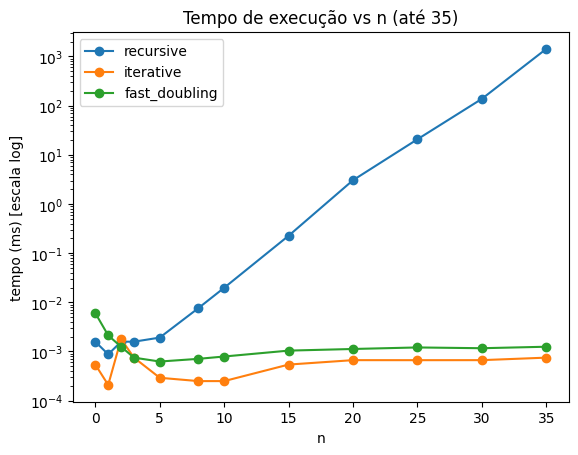

In [3]:

# Gráfico: tempo vs n (escala log no eixo y)
plt.figure()
for algo in df_small['algo'].unique():
    sub = df_small[df_small['algo'] == algo]
    plt.plot(sub['n'].values, sub['time_ms'].values, marker='o', label=algo)
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('tempo (ms) [escala log]')
plt.title('Tempo de execução vs n (até 35)')
plt.legend()
plt.show()


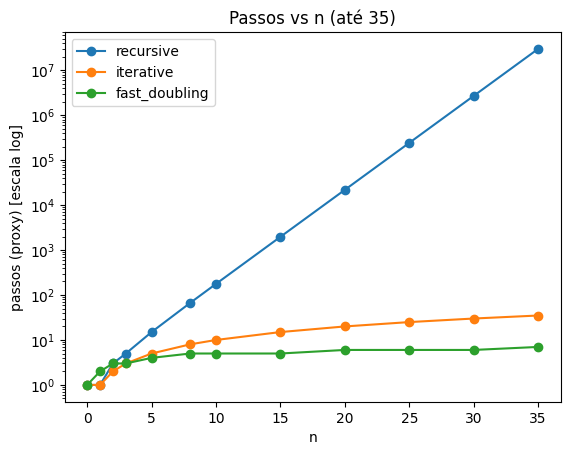

In [4]:

# Gráfico: passos vs n (escala log no eixo y)
plt.figure()
for algo in df_small['algo'].unique():
    sub = df_small[df_small['algo'] == algo]
    plt.plot(sub['n'].values, sub['steps'].values, marker='o', label=algo)
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('passos (proxy) [escala log]')
plt.title('Passos vs n (até 35)')
plt.legend()
plt.show()


## 1.2) Análise (n grandes) — tabelas e gráficos

In [5]:

# Para n grandes, omitimos o recursivo ingênuo
n_large = [10, 100, 1_000, 10_000, 100_000, 1_000_000]

res_large = []
res_large += run_and_time(fib_iterative_with_counts, n_large, "iterative")
res_large += run_and_time(fib_fast_doubling_with_counts, n_large, "fast_doubling")

df_large = pd.DataFrame([r.__dict__ for r in res_large])

# Número de dígitos de F_n (evita printar inteiros gigantes)
df_large['digits'] = df_large['value'].apply(lambda x: 1 if x == 0 else int(math.log10(x)) + 1)
df_large_slim = df_large.drop(columns=['value'])
df_large_slim


,n,steps,time_ms,algo,digits
0,10,10,0.003792,iterative,2
1,100,100,0.007000,iterative,21
2,1000,1000,0.092000,iterative,209
3,10000,10000,2.947708,iterative,2090
4,100000,100000,109.037375,iterative,20899
5,1000000,1000000,9237.574875,iterative,208988
6,10,5,0.006875,fast_doubling,2
7,100,8,0.003500,fast_doubling,21
8,1000,11,0.004625,fast_doubling,209
9,10000,15,0.026500,fast_doubling,2090


In [ ]:

# Gráfico: tempo vs n (escala log-log)
plt.figure()
for algo in df_large['algo'].unique():
    sub = df_large[df_large['algo'] == algo]
    plt.plot(sub['n'].values, sub['time_ms'].values, marker='o', label=algo)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n [escala log]')
plt.ylabel('tempo (ms) [escala log]')
plt.title('Tempo de execução para n grandes (iterative vs fast_doubling)')
plt.legend()
plt.show()


In [ ]:

# Gráfico: passos vs n (escala log-log)
plt.figure()
for algo in df_large['algo'].unique():
    sub = df_large[df_large['algo'] == algo]
    plt.plot(sub['n'].values, sub['steps'].values, marker='o', label=algo)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n [escala log]')
plt.ylabel('passos (proxy) [escala log]')
plt.title('Passos para n grandes (iterative vs fast_doubling)')
plt.legend()
plt.show()
